In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt

import optuna
from optuna.trial import TrialState

##### Carregando o dataset

In [43]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [44]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

## Declarando as funções de avaliação do modelo

In [62]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [46]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [47]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [48]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [49]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [50]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [51]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [52]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [53]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo da Random Forest

In [9]:
model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=df_train.shape[1]
)

In [10]:
model.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=10, max_features=35, n_estimators=10)

## Avaliando o modelo

### Conjunto de Validação

In [55]:
y_pred_val_class = model.predict(X_val)
y_pred_val_scores = model.predict_proba(X_val)

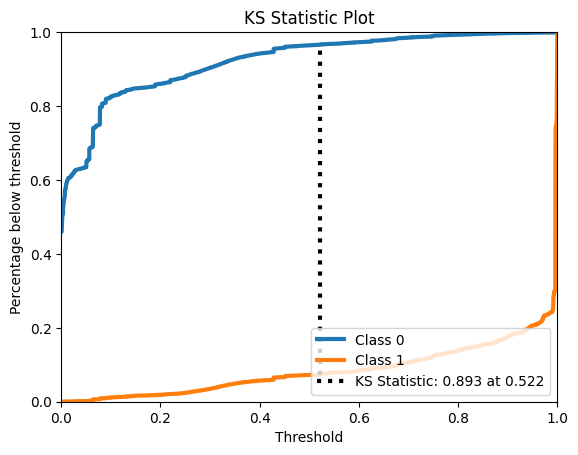



Random Forest - Validation

Accuracy:         0.9458
Recall:           0.9274
Precision:        0.9628
F1:               0.9447
AUROC:            0.9897
AUPR:             0.9900


In [57]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_val_class, y_pred_val_scores)
print('\n\nRandom Forest - Validation')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

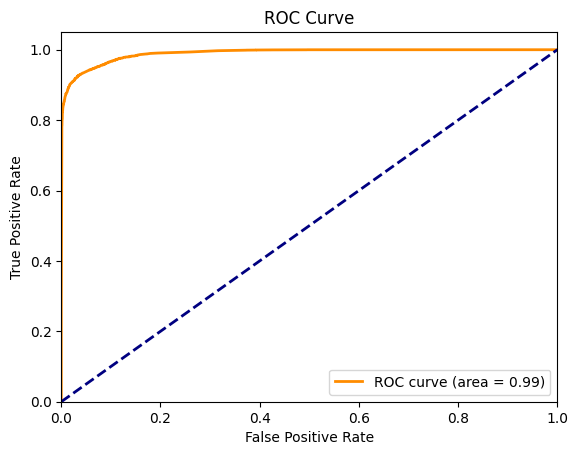

In [61]:
plot_roc_curve(y_pred_val_scores, y_val)

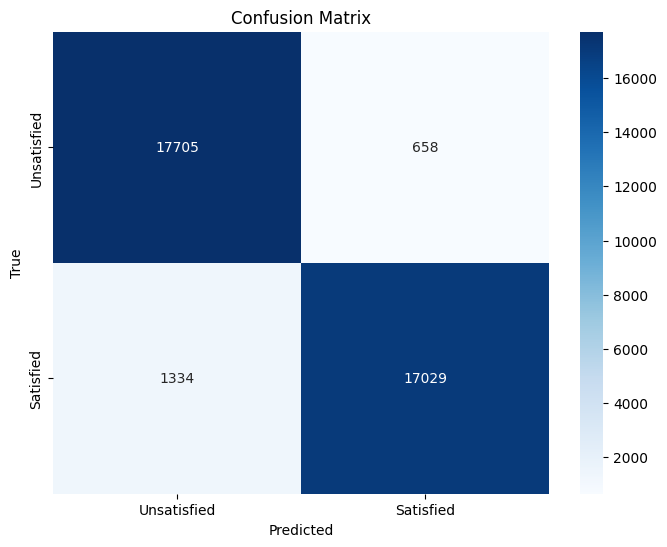

In [58]:
plot_confusion_matrix(y_pred=y_pred_val_class, y_test=y_val)

### Conjunto de Teste

In [67]:
y_pred_test_class = model.predict(X_test)
y_pred_test_scores = model.predict_proba(X_test)

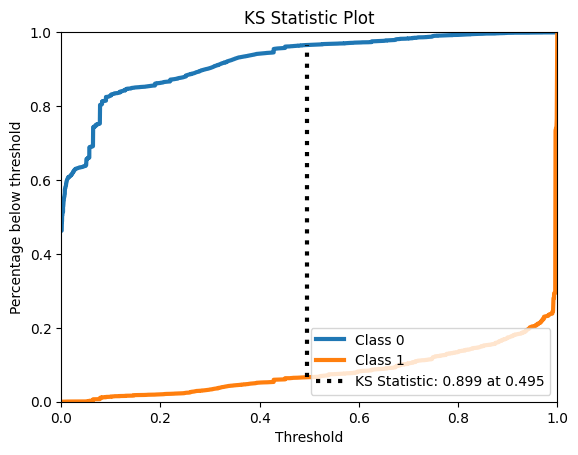



Random Forest - Test

Accuracy:         0.9516
Recall:           0.9334
Precision:        0.9541
F1:               0.9437
AUROC:            0.9900
AUPR:             0.9877


In [68]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
print('\n\nRandom Forest - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

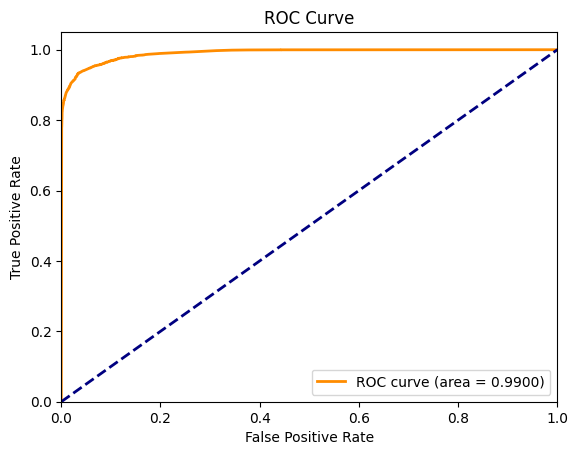

In [70]:
plot_roc_curve(y_pred_test_scores, y_test)

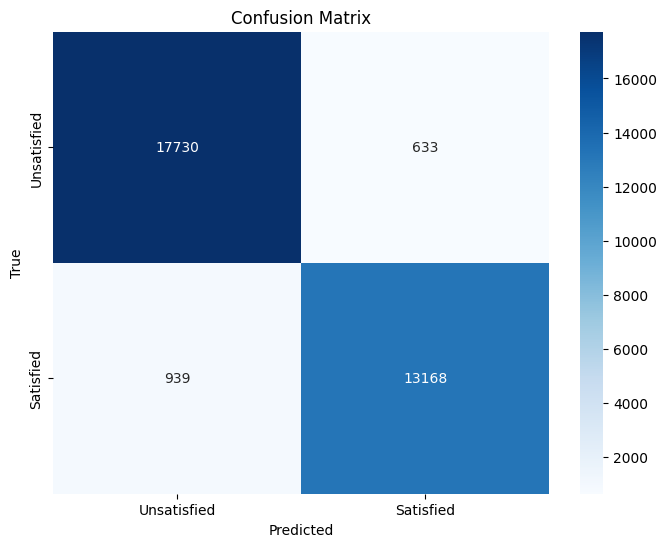

In [69]:
plot_confusion_matrix(y_pred=y_pred_test_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [75]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    y_pred_test_scores = model.predict_proba(X_test)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    
    return auroc


[I 2024-07-16 22:10:42,704] A new study created in memory with name: no-name-741d4644-3ea1-4818-96dd-77861ff22d90


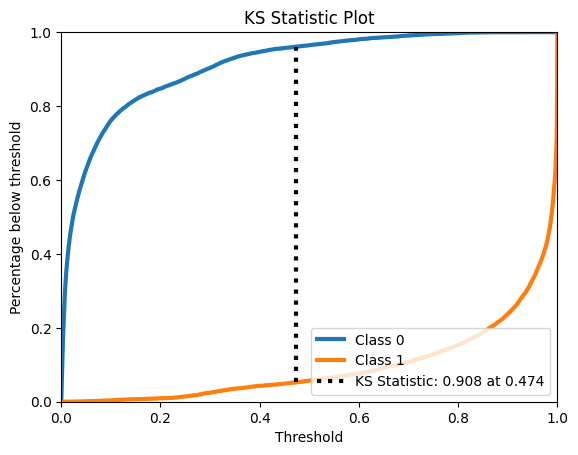

[I 2024-07-16 22:10:53,269] Trial 0 finished with value: 0.9926279432992584 and parameters: {'n_estimators': 257, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9926279432992584.




Random Forest
n_estimators: 257
max_depth:20
min_samples_split:8
min_samples_leaf:7

Accuracy:         0.9554
Recall:           0.9431
Precision:        0.9537
F1:               0.9484
AUROC:            0.9926
AUPR:             0.9915


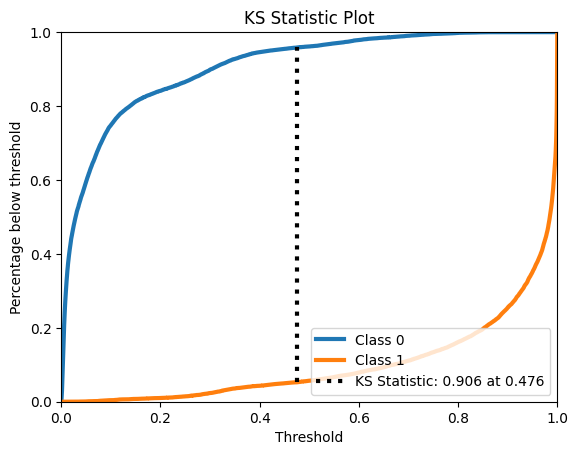

[I 2024-07-16 22:11:10,240] Trial 1 finished with value: 0.9920837019587513 and parameters: {'n_estimators': 425, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9926279432992584.




Random Forest
n_estimators: 425
max_depth:16
min_samples_split:13
min_samples_leaf:9

Accuracy:         0.9534
Recall:           0.9432
Precision:        0.9492
F1:               0.9462
AUROC:            0.9921
AUPR:             0.9909


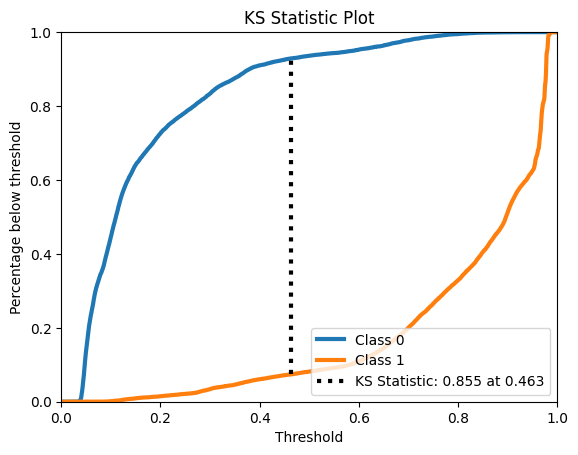

[I 2024-07-16 22:11:15,352] Trial 2 finished with value: 0.9786949785656718 and parameters: {'n_estimators': 209, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9926279432992584.




Random Forest
n_estimators: 209
max_depth:6
min_samples_split:10
min_samples_leaf:4

Accuracy:         0.9284
Recall:           0.9185
Precision:        0.9169
F1:               0.9177
AUROC:            0.9787
AUPR:             0.9752


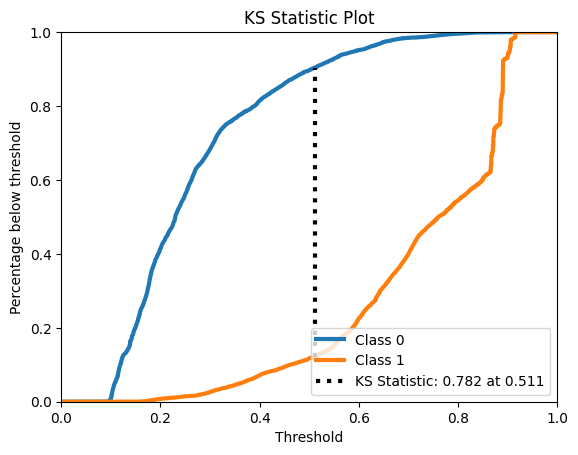

[I 2024-07-16 22:11:17,092] Trial 3 finished with value: 0.9561906933271579 and parameters: {'n_estimators': 98, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9926279432992584.




Random Forest
n_estimators: 98
max_depth:3
min_samples_split:8
min_samples_leaf:5

Accuracy:         0.8907
Recall:           0.8825
Precision:        0.8681
F1:               0.8753
AUROC:            0.9562
AUPR:             0.9479


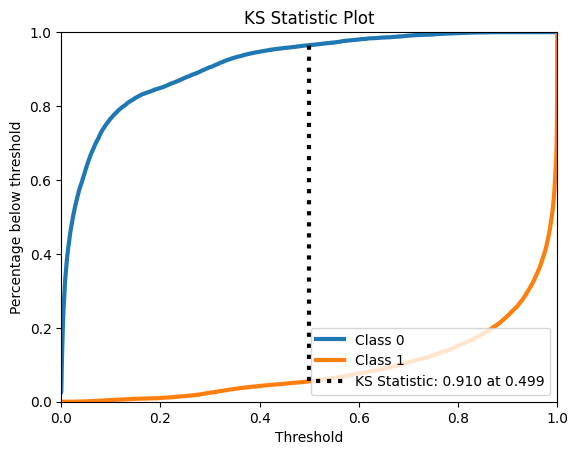

[I 2024-07-16 22:11:20,892] Trial 4 finished with value: 0.9926299120551716 and parameters: {'n_estimators': 83, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.9926299120551716.




Random Forest
n_estimators: 83
max_depth:17
min_samples_split:6
min_samples_leaf:6

Accuracy:         0.9562
Recall:           0.9450
Precision:        0.9538
F1:               0.9494
AUROC:            0.9926
AUPR:             0.9915


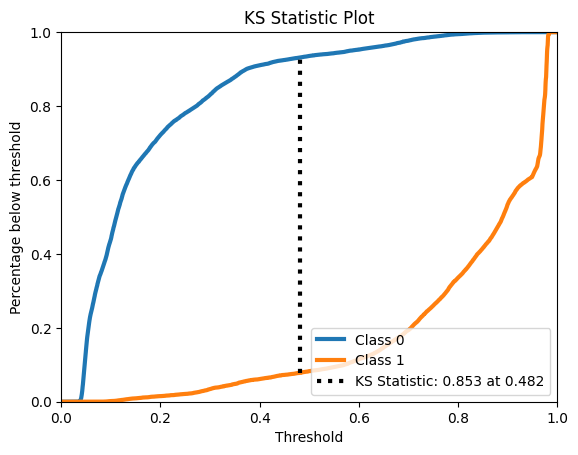

[I 2024-07-16 22:11:31,324] Trial 5 finished with value: 0.9781100611838768 and parameters: {'n_estimators': 443, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.9926299120551716.




Random Forest
n_estimators: 443
max_depth:6
min_samples_split:8
min_samples_leaf:7

Accuracy:         0.9276
Recall:           0.9173
Precision:        0.9162
F1:               0.9168
AUROC:            0.9781
AUPR:             0.9744


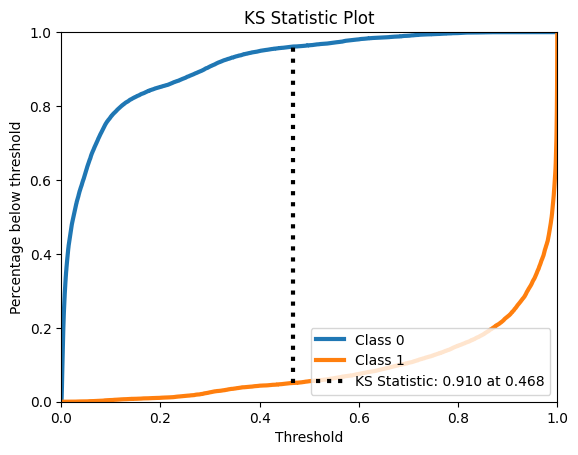

[I 2024-07-16 22:11:50,836] Trial 6 finished with value: 0.9926971199776183 and parameters: {'n_estimators': 468, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.9926971199776183.




Random Forest
n_estimators: 468
max_depth:16
min_samples_split:6
min_samples_leaf:5

Accuracy:         0.9558
Recall:           0.9446
Precision:        0.9532
F1:               0.9489
AUROC:            0.9927
AUPR:             0.9916


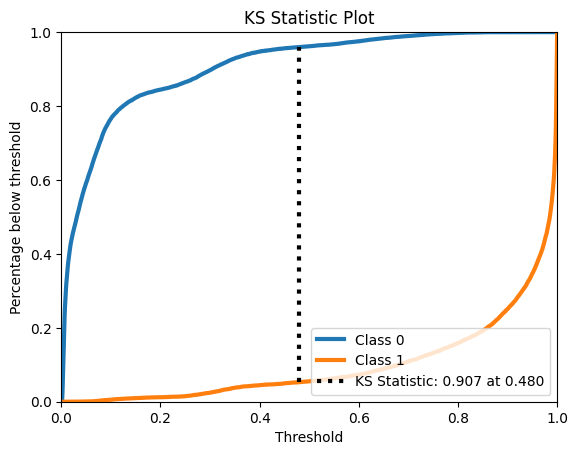

[I 2024-07-16 22:11:58,014] Trial 7 finished with value: 0.9918975252047177 and parameters: {'n_estimators': 176, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.9926971199776183.




Random Forest
n_estimators: 176
max_depth:13
min_samples_split:13
min_samples_leaf:3

Accuracy:         0.9545
Recall:           0.9450
Precision:        0.9500
F1:               0.9475
AUROC:            0.9919
AUPR:             0.9907


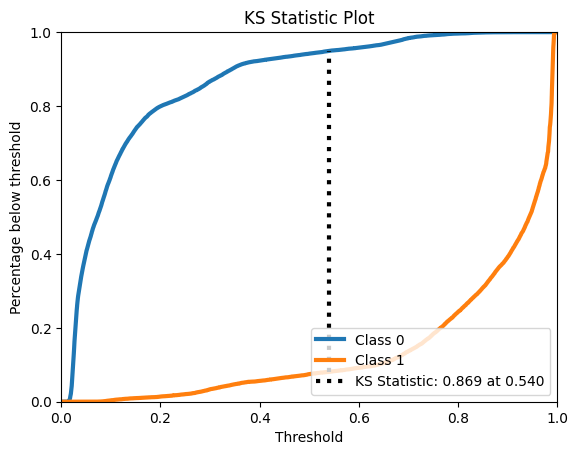

[I 2024-07-16 22:12:02,642] Trial 8 finished with value: 0.9855349403778293 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 6 with value: 0.9926971199776183.




Random Forest
n_estimators: 150
max_depth:8
min_samples_split:2
min_samples_leaf:10

Accuracy:         0.9346
Recall:           0.9252
Precision:        0.9243
F1:               0.9248
AUROC:            0.9855
AUPR:             0.9835


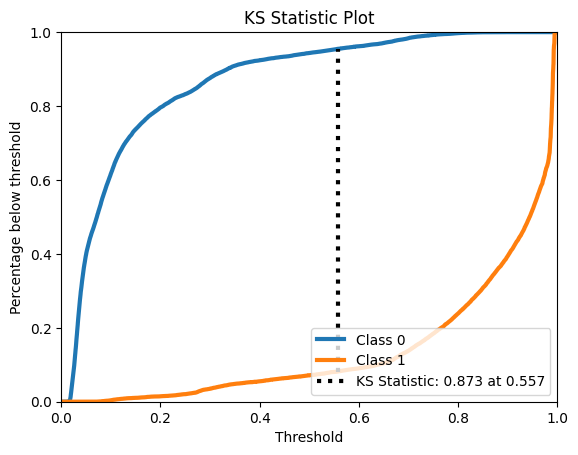

[I 2024-07-16 22:12:04,459] Trial 9 finished with value: 0.9858608524780272 and parameters: {'n_estimators': 52, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9926971199776183.




Random Forest
n_estimators: 52
max_depth:8
min_samples_split:7
min_samples_leaf:2

Accuracy:         0.9369
Recall:           0.9283
Precision:        0.9266
F1:               0.9274
AUROC:            0.9859
AUPR:             0.9840


In [76]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [79]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values("value")  # Sort based on accuracy

csv_file = "optuna_results_rf.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [82]:
df_existing.sort_values("user_attrs_auroc")

,number,value,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,user_attrs_accuracy,user_attrs_auroc,user_attrs_f1,user_attrs_max_depth,user_attrs_min_samples_leaf,user_attrs_min_samples_split,user_attrs_n_estimators,user_attrs_precision,user_attrs_recall
3,3,0.956191,3,5,8,98,0.890699,0.956191,0.868080,3,5,8,98,0.868080,0.882541
5,5,0.978110,6,7,8,443,0.927626,0.978110,0.916236,6,7,8,443,0.916236,0.917275
2,2,0.978695,6,4,10,209,0.928395,0.978695,0.916855,6,4,10,209,0.916855,0.918480
8,8,0.985535,8,10,2,150,0.934586,0.985535,0.924297,8,10,2,150,0.924297,0.925214
9,9,0.985861,8,2,7,52,0.936896,0.985861,0.926560,8,2,7,52,0.926560,0.928333
7,7,0.991898,13,3,13,176,0.954512,0.991898,0.950043,13,3,13,176,0.950043,0.944992
1,1,0.992084,16,9,13,425,0.953403,0.992084,0.949208,16,9,13,425,0.949208,0.943220
0,0,0.992628,20,7,8,257,0.955405,0.992628,0.953695,20,7,8,257,0.953695,0.943149
4,4,0.992630,17,6,6,83,0.956237,0.992630,0.953849,17,6,6,83,0.953849,0.944992
6,6,0.992697,16,5,6,468,0.955805,0.992697,0.953219,16,5,6,468,0.953219,0.944637


In [87]:
best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.value}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9926971199776183
  Precision: 0.9532188841201716
  Recall:    0.9446374140497625
  F1 Score:  0.9532188841201716
  auroc:  0.9926971199776183
  Parameters: 
    n_estimators:     468
    max_depth:        16
    min_samples_split: 6
    min_samples_leaf: 5

-- Overall Results (Ordered by auroc) --
   number     value  params_max_depth  params_min_samples_leaf  \
3       3  0.956191                 3                        5   
5       5  0.978110                 6                        7   
2       2  0.978695                 6                        4   
8       8  0.985535                 8                       10   
9       9  0.985861                 8                        2   
7       7  0.991898                13                        3   
1       1  0.992084                16                        9   
0       0  0.992628                20                        7   
4       4  0.992630                17                        6   
6       